In [4]:
import glob, os, sys, re, time, subprocess, gzip, itertools, pickle

from random import seed
seed(42)

import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#import MultiProcessing

import simons_meta_data
from plotting_tools import d3, SwapPalette, SwapStyle, SwapContext
from horizon_plot import horizon_plot


In [5]:
# set up parallel computing.
# only works if ipcluster runs on the same node:
# ipcluster start -n <nr_available_cores_on_node>

import ipyparallel as ipp

ipp_client = ipp.Client()
ipp_direct_view = ipp_client[:]
ipp_view = ipp_client.load_balanced_view()


In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# default style
sns.set_style("whitegrid")
sns.set_context("paper")

In [7]:
class Timer(object):
    
    def __init__(self, verbose=False):
        self.verbose = verbose

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.secs = self.end - self.start
        self.msecs = self.secs * 1000  # millisecs
        if self.verbose:
            print('elapsed time: {} ms'.format(self.msecs))

# Load data and compute $\pi$ in windows

In [8]:
meta_data, populations, regions = simons_meta_data.get_meta_data()

# project root dir
faststorage = '/home/kmt/simons/faststorage'
mydir = '/home/kmt/simons/faststorage/people/kmt'

# chromosome names as strings
chromosome_names = [str(x) for x in range(1,23)] + ['X']

# get file names for each pseudohaploid
pseudohaploid_sample_files = dict()
for file_name in glob.glob(os.path.join(mydir, 'steps', 
            'pseudohaploid_genomes', '*.fa.gz')):
    base = os.path.basename(file_name)
    individual, chrom = re.match(r'(.*)-([AB]).fa.gz', base).groups()
    pseudohaploid_sample_files[(individual, chrom)] = file_name
    

In [9]:
#assert 0, "don't run by mistake"



def pi_for_pair(f1, f2, binsize, pop, indiv1, pseud1, indiv2, pseud2):

    
    def win_generator(file_name1, file_name2, binsize):

        with gzip.open(file_name1, 'r') as stream1:
            genome1 = dict()
            for s in stream1.read().decode().split('>')[1:]:
                header, seq = s.split('\n', 1)
                chrom = header.split()[0]
                genome1[chrom] = seq.replace('\n', '').encode()

        with gzip.open(file_name2, 'r') as stream2:
            genome2 = dict()
            for s in stream2.read().decode().split('>')[1:]:
                header, seq = s.split('\n', 1)
                chrom = header.split()[0]
                genome2[chrom] = seq.replace('\n', '').encode()

        for chrom in list(range(1, 23)) + ['X']:
            seq1 = genome1[str(chrom)]
            seq2 = genome2[str(chrom)]
            assert len(seq1) == len(seq2)
            for binstart in range(0, len(seq1)-binsize, binsize):
                yield (chrom, binstart, 
                       seq1[binstart:binstart+binsize],
                       seq2[binstart:binstart+binsize])

        
    result_list = list()

    # iter windows
    for chrom, start, win1, win2 in win_generator(f1, f2, binsize):
        assert len(win1) == len(win2) == binsize, (len(win1), len(win2))

        # int repr of chars
        N = ord('N')
        gap = ord('-')
        uncalled, match, mismatch = 0, 0, 0

        # count site classes
        for a, b in zip(win1, win2):
            if a == N or a == gap or b == N or b == gap:
                uncalled += 1
            elif a == b:
                match += 1
            else:
                mismatch += 1

        if mismatch + match:
            pi = mismatch / (mismatch + match)
        else:
            pi = np.nan
                
        # add to result table
        result_list.append([chrom, start, start+binsize, pop, 
                         indiv1, pseud1, indiv2, pseud2,
                         pi, mismatch, match, uncalled])
    return result_list
        

    
# size of windows for computing pi
binsize = 100000
    
arg_list = list()
# iter populations
for pop, pop_samples in populations.items():
    
    tups = \
        [(indiv, 'A', '{}-A.fa.gz'.format(indiv)) for indiv in pop_samples] + \
        [(indiv, 'B', '{}-B.fa.gz'.format(indiv)) for indiv in pop_samples]
    
    # iter pseudohaploid pairs
    for (indiv1, pseud1, file1), (indiv2, pseud2, file2) in itertools.combinations(tups, 2):
        
        # we do not compare chromosome from the same 
        # individul to avoid inbreeding arterfcts
        if indiv1 == indiv2:
            continue
            
        # open files for the pair of pseudohaploids to compare
        f1 = os.path.join(mydir, 'steps',
                               'pseudohaploid_genomes', file1)
        f2 = os.path.join(mydir, 'steps', 
                               'pseudohaploid_genomes', file2)
    
        arg_list.append([f1, f2, binsize, pop, indiv1, pseud1, indiv2, pseud2])

        
ipp_direct_view.execute('import gzip')
ipp_direct_view.execute('import numpy as np')


tot = len(arg_list)
pi_table = list()
#for i, sub_table in enumerate(MultiProcessing.Broadcast(15, pi_for_pair, *zip(*arg_list))):

#for i, sub_table in enumerate(map(pi_for_pair, *zip(*arg_list))):
for i, sub_table in enumerate(ipp_view.map(pi_for_pair, *zip(*arg_list))):

    if not i % 10:
        print(i, 'of', tot)

    with open(os.path.join(mydir, 'steps/pi_tmp_tables/{}.pickle'.format(i)), 'wb') as f:
        pickle.dump(sub_table, f)

    pi_table.extend(sub_table)

    with open(os.path.join(mydir, 'steps/pi_tmp_tables/accumulating.pickle'), 'wb') as f:
        pickle.dump(pi_table, f)

    

0 of 1172


CompositeError: one or more exceptions from call to method: pi_for_pair
[1:apply]: FileNotFoundError: [Errno 2] No such file or directory: '/home/kmt/simons/faststorage/people/kmt/steps/pseudohaploid_genomes/B_Ju_hoan_North-4-A.fa.gz'

In [21]:
   
pi_df = pd.DataFrame(pi_table, columns=['chrom', 'start', 'end', 'pop', 
                             'indiv1', 'pseud1', 'indiv2', 'pseud2',
                             'pi', 'mismatch', 'match', 'uncalled'])


#merge pi_df with meta_data
lst = list()
for i, d in meta_data.items()
    for k in sorted(d.keys()):
        
        

meta_df = pd.DataFrame([])

pi_df.to_csv(path_or_buf='../steps/pi_{}.tsv'.format(binsize), sep='\t')

[('S_Papuan-13', 'A', 'S_Papuan-13-A.fa.gz'), ('A_Papuan-16', 'A', 'A_Papuan-16-A.fa.gz'), ('S_Papuan-11', 'A', 'S_Papuan-11-A.fa.gz'), ('S_Papuan-7', 'A', 'S_Papuan-7-A.fa.gz'), ('S_Papuan-9', 'A', 'S_Papuan-9-A.fa.gz'), ('S_Papuan-8', 'A', 'S_Papuan-8-A.fa.gz'), ('S_Papuan-10', 'A', 'S_Papuan-10-A.fa.gz'), ('S_Papuan-6', 'A', 'S_Papuan-6-A.fa.gz'), ('S_Papuan-14', 'A', 'S_Papuan-14-A.fa.gz'), ('S_Papuan-12', 'A', 'S_Papuan-12-A.fa.gz'), ('S_Papuan-2', 'A', 'S_Papuan-2-A.fa.gz'), ('S_Papuan-1', 'A', 'S_Papuan-1-A.fa.gz'), ('S_Papuan-3', 'A', 'S_Papuan-3-A.fa.gz'), ('S_Papuan-4', 'A', 'S_Papuan-4-A.fa.gz'), ('S_Papuan-5', 'A', 'S_Papuan-5-A.fa.gz'), ('B_Papuan-15', 'A', 'B_Papuan-15-A.fa.gz'), ('S_Papuan-13', 'B', 'S_Papuan-13-B.fa.gz'), ('A_Papuan-16', 'B', 'A_Papuan-16-B.fa.gz'), ('S_Papuan-11', 'B', 'S_Papuan-11-B.fa.gz'), ('S_Papuan-7', 'B', 'S_Papuan-7-B.fa.gz'), ('S_Papuan-9', 'B', 'S_Papuan-9-B.fa.gz'), ('S_Papuan-8', 'B', 'S_Papuan-8-B.fa.gz'), ('S_Papuan-10', 'B', 'S_Papuan-10

AssertionError: 

# Explorative quick analysis
    

In [ ]:

with sns.axes_style("ticks"):
    sns.boxplot(x="region", y="pi", hue="pop", data=pi_df, palette="PRGn")
    sns.despine(offset=10, trim=True)
    plt.show()

# $\pi$ on the map

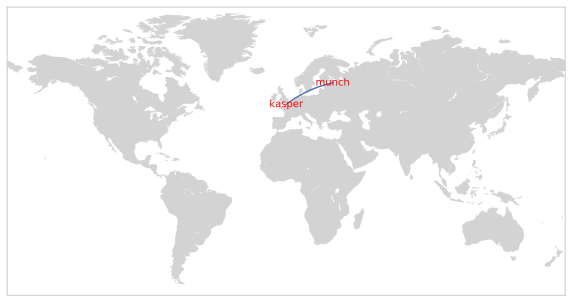

In [17]:
from mpl_toolkits.basemap import Basemap
# import numpy as np
import matplotlib.pyplot as plt

with d3():
    plt.figure(figsize=(10,6), frameon=False)
    # llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon are the lat/lon values of the lower 
    # left and upper right corners of the map. resolution = 'c' is crude, l is low, 
    # i is intermediate, h is high, f is full
    m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=85,\
                llcrnrlon=-180,urcrnrlon=180,resolution='c')
    #m.drawcoastlines()
    m.fillcontinents(color='lightgrey',lake_color='white')
    #m.drawrivers()

    # map has its own plot function that can take lat/long vals
    #m.plot(50, -30, "or", latlon=True)

    # plot many text labels on a map
    long = [0, 30]
    lat = [50, 60]
    text = ['kasper', 'munch']
    for x, y, text in zip(*m(long, lat), text):
        #plt.plot(x, y, 'or')
        plt.text(x, y, text, color='red', fontsize=10, 
                  horizontalalignment='center', verticalalignment='center')
    m.drawgreatcircle(0, 50, 30, 60)
    plt.show()

# Spatial distributions of $\pi$ across the genome

## Horizon plot

In [ ]:

with Timer() as t:
    with SwapContext("notebook", font_scale=0.5):
        fig = horizon_plot(df, 'pi', width=100000) # width should be end-start (steps in time series)
        # save to file
        plt.savefig('../plots/pi.pdf')
        # suppress inline plot
        plt.close(fig)    
print(t.secs)
  

## log scale horizon plot

## quantile normalization



If we quantile normalize then we make all the high ones the mean of each other and the same for the low ones. If landscapes only differ due to pool-nielsen then the ranks of

then they should now be the same. Each profile is forced to show the same number of low regions - which may show sweeps where where there are none.

But the low 100kb windoes should not be consequtive if they are not strong sweeps - or they shoul be more so if they are. 

So I could plot the length distribution of consequtive low regions in each population. That should, conservatively, show how many more low regions there are in some populations.

If these results are roughly the same as the differences between populations when we just count low regions without normalizting, then we are in good shape

Then I could argue that I have a highly sensitive and a highly specific method to identify differences (sweeps) between populations - and that the truth is in between.

In [ ]:
df = pd.DataFrame({'A': np.random.normal(size=100), 'B': np.random.normal(size=100, scale=3, loc=10)})

#aa = np.transpose(array([np.random.normal(10, size=10), np.random.normal(10, size=10, scale=3)]))

def quantile_normalization(df):
    A=df.as_matrix()
    AA = np.zeros_like(A)
    I = np.argsort(A,axis=0)
    AA[I,np.arange(A.shape[1])] = np.mean(A[I,np.arange(A.shape[1])],axis=1)[:,np.newaxis]
    return pd.DataFrame(AA, columns=df.columns)

#print df
#print quantile_normalization(df)
df.hist()
quantile_normalization(df).hist()


In [ ]:
df.plot(kind='line')
quantile_normalization(df).plot(kind='line')

In [ ]:
df = pd.DataFrame({'chrom':['chr1']*10, 'start':range(10), 'end': range(1, 11),
                   'A':np.linspace(0, 10, 10), 'B':np.linspace(0, 20, 10)})
print df

# inplace normalization

data_cols = [col for col in df.columns if col not in ['chrom', 'start', 'end']]
df[data_cols] = quantile_normalization(df[data_cols])
print df